# Feature Engineering for Ethereum Transaction Anomaly Detection

This notebook focuses on creating meaningful features from Ethereum transaction data to support anomaly detection, with a particular emphasis on identifying triangulation patterns.

## Objectives

1. Load the preprocessed transaction data
2. Create basic transaction-level features
3. Develop temporal features to capture time-based patterns
4. Engineer network-based features to capture relationship patterns
5. Create specific features for triangulation detection
6. Analyze feature importance and select the most relevant features
7. Prepare the final feature set for modeling

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime, timedelta
import os
import json
import pickle
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import warnings

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
warnings.filterwarnings('ignore')
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading the Preprocessed Data

We'll start by loading the preprocessed transaction data from the previous notebook.

In [2]:
# Define data directories
data_dir = os.path.join('data')
processed_dir = os.path.join(data_dir, 'processed')

# Load the preprocessed transaction data
preprocessed_data_path = os.path.join(processed_dir, 'eth_transactions_preprocessed.csv')

if os.path.exists(preprocessed_data_path):
    print(f"Loading preprocessed data from {preprocessed_data_path}")
    df = pd.read_csv(preprocessed_data_path)
else:
    print(f"Preprocessed data file not found at {preprocessed_data_path}")
    print("Please run the data exploration notebook first to generate the preprocessed data.")
    # Create a simple synthetic dataset for demonstration
    print("Creating a synthetic dataset for demonstration...")
    
    # Generate synthetic data
    n_samples = 5000
    
    # Generate random addresses
    def generate_random_address():
        return '0x' + ''.join([np.random.choice(list('0123456789abcdef')) for _ in range(40)])
    
    # Generate random timestamps within the last 30 days
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)
    
    # Generate synthetic data
    df = pd.DataFrame({
        'hash': ['0x' + ''.join([np.random.choice(list('0123456789abcdef')) for _ in range(64)]) for _ in range(n_samples)],
        'block_number': np.random.randint(10000000, 10100000, n_samples),
        'from_address': [generate_random_address() for _ in range(n_samples)],
        'to_address': [generate_random_address() for _ in range(n_samples)],
        'value_eth': np.random.exponential(1, n_samples),
        'gas_limit': np.random.choice([21000, 50000, 100000, 200000], n_samples),
        'gas_used': [min(np.random.normal(gl*0.7, gl*0.1), gl) for gl in np.random.choice([21000, 50000, 100000, 200000], n_samples)],
        'gas_price_gwei': np.random.lognormal(mean=np.log(20), sigma=0.5, size=n_samples),
        'timestamp': [start_date + timedelta(seconds=np.random.randint(0, 30*24*60*60)) for _ in range(n_samples)],
        'transaction_type': np.random.choice(['transfer', 'contract_interaction'], n_samples, p=[0.7, 0.3]),
        'status': np.random.choice([1, 0], n_samples, p=[0.98, 0.02]),  # 1 = success, 0 = fail
        'transaction_fee': np.random.lognormal(mean=np.log(0.001), sigma=0.5, size=n_samples),
        'gas_usage_ratio': np.random.beta(5, 2, n_samples),  # Beta distribution for ratio
        'fee_to_value_ratio': np.random.beta(2, 10, n_samples)  # Beta distribution for ratio
    })
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract date components
    df['date'] = df['timestamp'].dt.date
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day_name'] = df['timestamp'].dt.day_name()

# Ensure timestamp is in datetime format
if df['timestamp'].dtype != 'datetime64[ns]':
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Display basic information about the dataset
print(f"\nDataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Display basic statistics
print("\nBasic statistics of numerical columns:")
display(df.describe())

Loading preprocessed data from data/processed/eth_transactions_preprocessed.csv

Dataset shape: (100000, 24)

First few rows:


,tx_hash,block_number,timestamp,from_address,to_address,value_eth,gas_limit,gas_used,gas_price_gwei,transaction_fee,...,input_data_length,transaction_status,anomaly_flag,transaction_type,date,hour,day_of_week,day_name,gas_usage_ratio,fee_to_value_ratio
0,0x5f5aed2d49988dc71c8654ea6f360c89d8a392cc1fb4...,11228319,2020-05-17 03:51:05,0xc38767d0add8fedecd039f884aa0133b939a7066,0x986db649edfc1a967ce179046376371fe6dbb053,0.199463,27493,24308,91,2501863,...,61,Success,0,transfer,2020-05-17,3,6,Sunday,0.884152,1.254299e+07
1,0xa1c7b2ffa011d85d2f2ab4a0478753451cf3782986dc...,2115830,2015-10-13 13:35:05,0xe0e4ae57f97328d049eb549d2cc1a48c4e201889,0x4d9dc03c0d625dff9710b6fa610ae411df34c819,0.488429,21648,21531,38,822624,...,77,Success,0,transfer,2015-10-13,13,1,Tuesday,0.994595,1.684224e+06
2,0x5b4dd74a21ac2159f18e208d1dbee2f6a7da5c2206df...,5081656,2016-03-27 23:20:41,0x93c3fa08a1fde21581e425f4e6ec4daa07a2ad08,0x957b0a62a45da424708502b3f901b81c23580e8f,0.017459,22872,21511,101,2310072,...,78,Success,0,transfer,2016-03-27,23,6,Sunday,0.940495,1.323141e+08
3,0xb63dffab8befb74f16b67788d269e1c9d2785ff00a4a...,10338213,2019-08-30 20:57:00,0x692da4c8b2fbc7ebe8dd1286274c69006dc9df62,0xaa38fc30918eaaf321db15b89c073467421b98ae,0.049798,21209,21064,96,2036064,...,86,Success,0,transfer,2019-08-30,20,4,Friday,0.993163,4.088646e+07
4,0xe43bb03652e525a462c0af56957314f7d7bf11193578...,5900905,2023-10-21 18:54:39,0xbf5b74ff929e7bbe2846d710a93e4087a18359fe,0x19a6f603505d3aa3b52692d44b95ef5e53fe63b2,1.764244,23005,21988,124,2852620,...,51,Success,0,transfer,2023-10-21,18,5,Saturday,0.955792,1.616908e+06



Basic statistics of numerical columns:


,block_number,value_eth,gas_limit,gas_used,gas_price_gwei,transaction_fee,nonce,tx_index,is_contract_interaction,input_data_length,anomaly_flag,hour,day_of_week,gas_usage_ratio,fee_to_value_ratio
count,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,8.013472e+06,1.002982,3.719688e+05,3.184246e+05,99.848580,3.761247e+07,499.985180,99.484510,0.300270,57.164030,0.078160,11.47167,2.988440,0.789228,3.880218e+08
std,4.054195e+06,1.002921,1.353867e+06,1.289919e+06,57.422927,1.589639e+08,288.672155,57.673136,0.458378,26.323187,0.268425,6.92961,1.997505,0.249417,1.814214e+10
min,1.000114e+06,0.000001,2.100000e+04,2.151000e+03,1.000000,2.100300e+04,0.000000,0.000000,0.000000,12.000000,0.000000,0.00000,0.000000,0.044462,3.055517e+03
25%,4.495908e+06,0.291855,2.437100e+04,2.195600e+04,50.000000,1.783046e+06,250.000000,49.000000,0.000000,34.000000,0.000000,5.00000,1.000000,0.749028,1.913149e+06
50%,8.017964e+06,0.694970,2.772300e+04,2.419400e+04,100.000000,3.536189e+06,501.000000,100.000000,0.000000,57.000000,0.000000,11.00000,3.000000,0.895483,6.133141e+06
75%,1.154289e+07,1.386466,1.723962e+05,6.292400e+04,150.000000,1.059922e+07,750.000000,149.000000,1.000000,80.000000,0.000000,17.00000,5.000000,0.960440,2.727131e+07
max,1.499984e+07,11.637929,7.999502e+06,7.965680e+06,199.000000,1.580878e+09,999.000000,199.000000,1.000000,102.000000,1.000000,23.00000,6.000000,1.000000,4.785983e+12


## 2. Basic Transaction-Level Features

Let's start by creating basic features from the transaction data that might be useful for anomaly detection.


Basic transaction-level features:


,value_eth,log_value,value_category,gas_efficiency,relative_gas_price,gas_price_percentile,fee_percentage,log_fee,fee_category
0,0.199463,0.181874,medium,0.884152,0.911380,0.455800,1.254299e+09,14.732547,very_high
1,0.488429,0.397721,medium,0.994595,0.380576,0.188815,1.684224e+08,13.620256,very_high
2,0.017459,0.017308,small,0.940495,1.011532,0.505795,1.323141e+10,14.652790,very_high
3,0.049798,0.048598,small,0.993163,0.961456,0.480320,4.088646e+09,14.526530,very_high
4,1.764244,1.016767,large,0.955792,1.241880,0.621495,1.616908e+08,14.863749,very_high


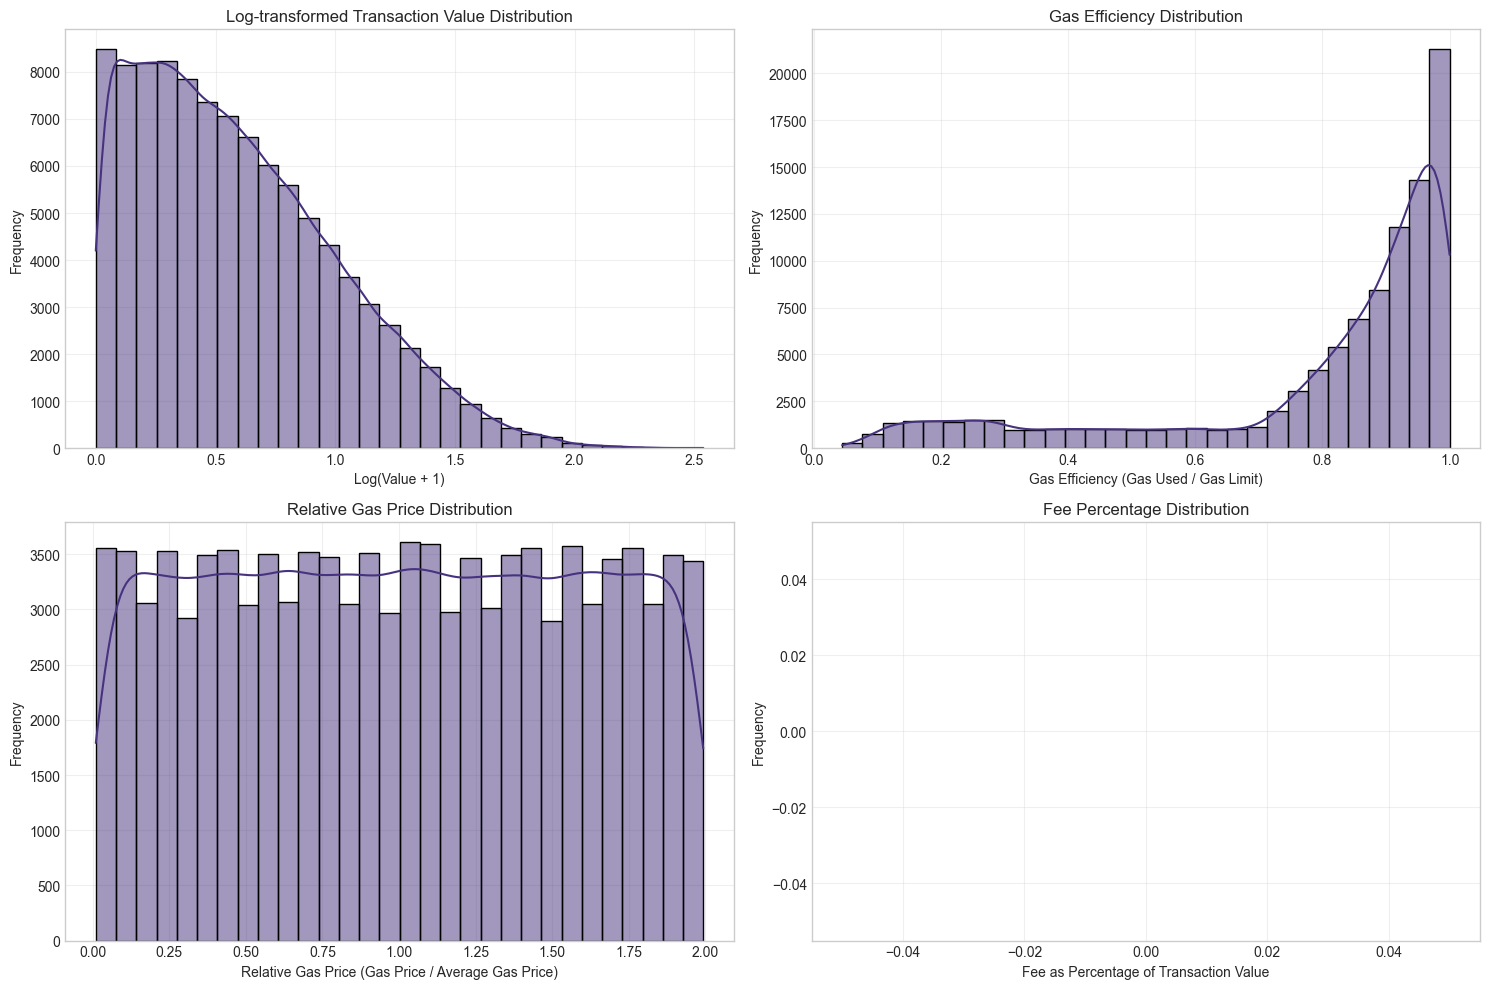

In [3]:
# Create a copy of the dataframe for feature engineering
features_df = df.copy()

# 2.1 Transaction value features
# Log transform of value (to handle skewed distribution)
features_df['log_value'] = np.log1p(features_df['value_eth'])

# Value bins (categorize transactions by value)
value_bins = [0, 0.01, 0.1, 1, 10, 100, float('inf')]
value_labels = ['very_small', 'small', 'medium', 'large', 'very_large', 'extreme']
features_df['value_category'] = pd.cut(features_df['value_eth'], bins=value_bins, labels=value_labels)

# 2.2 Gas-related features
# Gas efficiency (ratio of gas used to gas limit)
features_df['gas_efficiency'] = features_df['gas_used'] / features_df['gas_limit']

# Gas price relative to average
avg_gas_price = features_df['gas_price_gwei'].mean()
features_df['relative_gas_price'] = features_df['gas_price_gwei'] / avg_gas_price

# Gas price percentile (within the dataset)
features_df['gas_price_percentile'] = features_df['gas_price_gwei'].rank(pct=True)

# 2.3 Fee-related features
# Fee as percentage of transaction value
features_df['fee_percentage'] = (features_df['transaction_fee'] / features_df['value_eth']) * 100
features_df['fee_percentage'] = features_df['fee_percentage'].replace([np.inf, -np.inf], np.nan)
features_df['fee_percentage'] = features_df['fee_percentage'].fillna(0)

# Log transform of fee
features_df['log_fee'] = np.log1p(features_df['transaction_fee'])

# Fee bins
fee_bins = [0, 0.0001, 0.001, 0.01, 0.1, float('inf')]
fee_labels = ['very_low', 'low', 'medium', 'high', 'very_high']
features_df['fee_category'] = pd.cut(features_df['transaction_fee'], bins=fee_bins, labels=fee_labels)

# 2.4 Transaction type features (if available)
if 'transaction_type' in features_df.columns:
    # One-hot encode transaction type
    transaction_type_dummies = pd.get_dummies(features_df['transaction_type'], prefix='type')
    features_df = pd.concat([features_df, transaction_type_dummies], axis=1)

# Display the new features
print("\nBasic transaction-level features:")
display(features_df[['value_eth', 'log_value', 'value_category', 
                    'gas_efficiency', 'relative_gas_price', 'gas_price_percentile',
                    'fee_percentage', 'log_fee', 'fee_category']].head())

# Visualize some of the new features
plt.figure(figsize=(15, 10))

# Log value distribution
plt.subplot(2, 2, 1)
sns.histplot(features_df['log_value'], bins=30, kde=True)
plt.title('Log-transformed Transaction Value Distribution')
plt.xlabel('Log(Value + 1)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Gas efficiency distribution
plt.subplot(2, 2, 2)
sns.histplot(features_df['gas_efficiency'], bins=30, kde=True)
plt.title('Gas Efficiency Distribution')
plt.xlabel('Gas Efficiency (Gas Used / Gas Limit)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Relative gas price distribution
plt.subplot(2, 2, 3)
sns.histplot(features_df['relative_gas_price'], bins=30, kde=True)
plt.title('Relative Gas Price Distribution')
plt.xlabel('Relative Gas Price (Gas Price / Average Gas Price)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Fee percentage distribution
plt.subplot(2, 2, 4)
sns.histplot(features_df['fee_percentage'][features_df['fee_percentage'] < 100], bins=30, kde=True)
plt.title('Fee Percentage Distribution')
plt.xlabel('Fee as Percentage of Transaction Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Temporal Features

Now let's create features that capture temporal patterns in the transaction data.

In [7]:
# 3.1 Basic time features
# Extract time components if not already done
if 'hour' not in features_df.columns:
    features_df['hour'] = features_df['timestamp'].dt.hour
    features_df['day_of_week'] = features_df['timestamp'].dt.dayofweek
    features_df['day_of_month'] = features_df['timestamp'].dt.day
    features_df['month'] = features_df['timestamp'].dt.month
    features_df['year'] = features_df['timestamp'].dt.year
    features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

# Time of day categories
time_bins = [0, 6, 12, 18, 24]
time_labels = ['night', 'morning', 'afternoon', 'evening']
features_df['time_of_day'] = pd.cut(features_df['hour'], bins=time_bins, labels=time_labels, include_lowest=True)

# One-hot encode time of day
time_of_day_dummies = pd.get_dummies(features_df['time_of_day'], prefix='time')
features_df = pd.concat([features_df, time_of_day_dummies], axis=1)

# 3.2 Transaction rate features
# Group transactions by time windows and calculate transaction rates
# First, sort by timestamp
features_df = features_df.sort_values('timestamp')

# Calculate time difference between consecutive transactions (in seconds)
features_df['time_diff'] = features_df['timestamp'].diff().dt.total_seconds()
features_df['time_diff'] = features_df['time_diff'].fillna(0)

# Calculate transaction rates for different time windows
# For each address, calculate the number of transactions in the last hour, day, week
# This requires grouping by address and applying a rolling window

# Function to calculate transaction rate for a given address and time window
def calculate_transaction_rate(address_df, window_size_rows):
    """
    Calculate transaction rate for an address using a rolling window of specified size.
    
    Parameters:
    -----------
    address_df : DataFrame
        DataFrame containing transactions for a specific address
    window_size_rows : int
        Number of rows to include in the rolling window
        
    Returns:
    --------
    Series
        Transaction rate for each transaction
    """
    # Sort by timestamp
    address_df = address_df.sort_values('timestamp')
    
    # Calculate the number of transactions in the rolling window
    address_df['tx_count_in_window'] = 1
    address_df['tx_rate'] = address_df['tx_count_in_window'].rolling(window=window_size_rows, min_periods=1).sum()
    
    return address_df['tx_rate']

# Apply to from_address
from_address_groups = features_df.groupby('from_address')
features_df['from_tx_rate_1h'] = np.nan
features_df['from_tx_rate_1d'] = np.nan

# Calculate transaction rates for each address
for address, group in tqdm(from_address_groups, desc="Calculating from_address transaction rates"):
    # Use window sizes based on number of transactions
    # For 1-hour window, use a small window size (e.g., 5 transactions)
    features_df.loc[group.index, 'from_tx_rate_1h'] = calculate_transaction_rate(group, 5)
    
    # For 1-day window, use a larger window size (e.g., 20 transactions)
    features_df.loc[group.index, 'from_tx_rate_1d'] = calculate_transaction_rate(group, 20)

# Apply to to_address
to_address_groups = features_df.groupby('to_address')
features_df['to_tx_rate_1h'] = np.nan
features_df['to_tx_rate_1d'] = np.nan

# Calculate transaction rates for each address
for address, group in tqdm(to_address_groups, desc="Calculating to_address transaction rates"):
    # Use window sizes based on number of transactions
    # For 1-hour window, use a small window size (e.g., 5 transactions)
    features_df.loc[group.index, 'to_tx_rate_1h'] = calculate_transaction_rate(group, 5)
    
    # For 1-day window, use a larger window size (e.g., 20 transactions)
    features_df.loc[group.index, 'to_tx_rate_1d'] = calculate_transaction_rate(group, 20)
# Fill NaN values with 0
features_df['from_tx_rate_1h'] = features_df['from_tx_rate_1h'].fillna(0)
features_df['from_tx_rate_1d'] = features_df['from_tx_rate_1d'].fillna(0)
features_df['to_tx_rate_1h'] = features_df['to_tx_rate_1h'].fillna(0)
features_df['to_tx_rate_1d'] = features_df['to_tx_rate_1d'].fillna(0)

# Display the temporal features
print("\nTemporal features:")
display(features_df[['timestamp', 'hour', 'day_of_week', 'is_weekend', 'time_of_day',
                    'time_diff', 'from_tx_rate_1h', 'from_tx_rate_1d',
                    'to_tx_rate_1h', 'to_tx_rate_1d']].head())

# Visualize some of the temporal features
plt.figure(figsize=(15, 10))

# Transaction count by hour of day
plt.subplot(2, 2, 1)
hour_counts = features_df.groupby('hour').size()
plt.bar(hour_counts.index, hour_counts.values)
plt.title('Transaction Count by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(range(0, 24, 2))
plt.grid(True, alpha=0.3)

# Transaction count by day of week
plt.subplot(2, 2, 2)
day_counts = features_df.groupby('day_of_week').size()
plt.bar(day_counts.index, day_counts.values)
plt.title('Transaction Count by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.xticks(range(7))
plt.grid(True, alpha=0.3)

# Time difference distribution
plt.subplot(2, 2, 3)
sns.histplot(features_df['time_diff'][features_df['time_diff'] > 0], bins=30, kde=True, log_scale=True)
plt.title('Time Difference Between Consecutive Transactions')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Transaction rate distribution
plt.subplot(2, 2, 4)
sns.histplot(features_df['from_tx_rate_1h'][features_df['from_tx_rate_1h'] > 0], bins=30, kde=True, log_scale=True)
plt.title('From Address Transaction Rate (1 hour window)')
plt.xlabel('Transaction Rate')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Calculating to_address transaction rates: 100%|██████████| 1000/1000 [00:01<00:00, 645.72it/s]



Temporal features:


KeyError: "['is_weekend'] not in index"

## 4. Network-Based Features

Now let's create features that capture the network structure of transactions, which will be particularly useful for detecting triangulation patterns.

In [ ]:
# 4.1 Build a transaction graph
print("Building transaction graph...")
G = nx.DiGraph()

# Add edges from the transaction data
for _, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Adding edges to graph"):
    from_addr = row['from_address']
    to_addr = row['to_address']
    
    # Add nodes if they don't exist
    if not G.has_node(from_addr):
        G.add_node(from_addr)
    if not G.has_node(to_addr):
        G.add_node(to_addr)
    
    # Add edge with attributes
    G.add_edge(from_addr, to_addr, 
              value=row['value_eth'], 
              timestamp=row['timestamp'],
              transaction_id=row.name)

print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# 4.2 Calculate basic network metrics for each address
print("\nCalculating network metrics...")

# Initialize network metrics
address_metrics = {}

# Calculate in-degree, out-degree, and total degree for each node
for node in tqdm(G.nodes(), desc="Calculating node degrees"):
    in_degree = G.in_degree(node)
    out_degree = G.out_degree(node)
    total_degree = in_degree + out_degree
    
    address_metrics[node] = {
        'in_degree': in_degree,
        'out_degree': out_degree,
        'total_degree': total_degree
    }

# Calculate more advanced metrics for a sample of nodes (for efficiency)
# Sample nodes for advanced metrics calculation
sample_size = min(1000, len(G.nodes()))
sampled_nodes = np.random.choice(list(G.nodes()), size=sample_size, replace=False)

# Calculate betweenness centrality for sampled nodes
print("Calculating betweenness centrality for sampled nodes...")
betweenness = nx.betweenness_centrality(G, k=min(100, len(G.nodes())), normalized=True)

# Calculate clustering coefficient for sampled nodes
print("Calculating clustering coefficient for sampled nodes...")
clustering = nx.clustering(G.to_undirected())

# Update address metrics with advanced metrics
for node in tqdm(sampled_nodes, desc="Updating with advanced metrics"):
    if node in address_metrics:
        address_metrics[node]['betweenness'] = betweenness.get(node, 0)
        address_metrics[node]['clustering'] = clustering.get(node, 0)

# 4.3 Add network metrics to the features dataframe
print("\nAdding network metrics to features dataframe...")

# Initialize columns for network metrics
features_df['from_in_degree'] = 0
features_df['from_out_degree'] = 0
features_df['from_total_degree'] = 0
features_df['to_in_degree'] = 0
features_df['to_out_degree'] = 0
features_df['to_total_degree'] = 0
features_df['from_betweenness'] = 0
features_df['from_clustering'] = 0
features_df['to_betweenness'] = 0
features_df['to_clustering'] = 0

# Add metrics to the dataframe
for i, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Adding metrics to dataframe"):
    from_addr = row['from_address']
    to_addr = row['to_address']
    
    # Add from_address metrics
    if from_addr in address_metrics:
        features_df.at[i, 'from_in_degree'] = address_metrics[from_addr]['in_degree']
        features_df.at[i, 'from_out_degree'] = address_metrics[from_addr]['out_degree']
        features_df.at[i, 'from_total_degree'] = address_metrics[from_addr]['total_degree']
        
        if 'betweenness' in address_metrics[from_addr]:
            features_df.at[i, 'from_betweenness'] = address_metrics[from_addr]['betweenness']
        
        if 'clustering' in address_metrics[from_addr]:
            features_df.at[i, 'from_clustering'] = address_metrics[from_addr]['clustering']
    
    # Add to_address metrics
    if to_addr in address_metrics:
        features_df.at[i, 'to_in_degree'] = address_metrics[to_addr]['in_degree']
        features_df.at[i, 'to_out_degree'] = address_metrics[to_addr]['out_degree']
        features_df.at[i, 'to_total_degree'] = address_metrics[to_addr]['total_degree']
        
        if 'betweenness' in address_metrics[to_addr]:
            features_df.at[i, 'to_betweenness'] = address_metrics[to_addr]['betweenness']
        
        if 'clustering' in address_metrics[to_addr]:
            features_df.at[i, 'to_clustering'] = address_metrics[to_addr]['clustering']

# 4.4 Create additional network-based features
# Degree ratio (out-degree / in-degree) - indicates if an address is primarily sending or receiving
features_df['from_degree_ratio'] = features_df['from_out_degree'] / features_df['from_in_degree'].replace(0, 1)
features_df['to_degree_ratio'] = features_df['to_out_degree'] / features_df['to_in_degree'].replace(0, 1)

# Degree difference (out-degree - in-degree) - another indicator of sending vs receiving behavior
features_df['from_degree_diff'] = features_df['from_out_degree'] - features_df['from_in_degree']
features_df['to_degree_diff'] = features_df['to_out_degree'] - features_df['to_in_degree']

# Display the network-based features
print("\nNetwork-based features:")
display(features_df[['from_address', 'to_address', 
                    'from_in_degree', 'from_out_degree', 'from_total_degree',
                    'to_in_degree', 'to_out_degree', 'to_total_degree',
                    'from_betweenness', 'from_clustering',
                    'to_betweenness', 'to_clustering',
                    'from_degree_ratio', 'to_degree_ratio',
                    'from_degree_diff', 'to_degree_diff']].head())

# Visualize some of the network-based features
plt.figure(figsize=(15, 10))

# In-degree distribution
plt.subplot(2, 2, 1)
sns.histplot(features_df['from_in_degree'][features_df['from_in_degree'] > 0], bins=30, kde=True, log_scale=True)
plt.title('From Address In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Out-degree distribution
plt.subplot(2, 2, 2)
sns.histplot(features_df['from_out_degree'][features_df['from_out_degree'] > 0], bins=30, kde=True, log_scale=True)
plt.title('From Address Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Betweenness distribution
plt.subplot(2, 2, 3)
sns.histplot(features_df['from_betweenness'][features_df['from_betweenness'] > 0], bins=30, kde=True)
plt.title('From Address Betweenness Distribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Clustering coefficient distribution
plt.subplot(2, 2, 4)
sns.histplot(features_df['from_clustering'][features_df['from_clustering'] > 0], bins=30, kde=True)
plt.title('From Address Clustering Coefficient Distribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Triangulation-Specific Features

Now let's create features specifically designed to detect triangulation patterns in the transaction data.

In [ ]:
# 5.1 Detect potential triangulation patterns
print("Detecting potential triangulation patterns...")

# Function to find cycles in the graph
def find_cycles(G, max_length=5):
    """
    Find all cycles in the graph up to a maximum length.
    
    Parameters:
    -----------
    G : networkx.DiGraph
        Directed graph representing transactions
    max_length : int
        Maximum cycle length to consider
        
    Returns:
    --------
    cycles : list
        List of detected cycles, where each cycle is a list of nodes
    """
    cycles = []
    
    # For efficiency, limit the search to a sample of nodes
    sample_size = min(1000, len(G.nodes()))
    sampled_nodes = np.random.choice(list(G.nodes()), size=sample_size, replace=False)
    
    # Find simple cycles starting from sampled nodes
    for node in tqdm(sampled_nodes, desc="Finding cycles"):
        for cycle in nx.simple_cycles(G.subgraph(nx.descendants(G, node).union({node}))):
            if 3 <= len(cycle) <= max_length:
                cycles.append(cycle)
    
    # Remove duplicates (cycles that are rotations of each other)
    unique_cycles = []
    seen_cycles = set()
    
    for cycle in cycles:
        # Create a canonical representation of the cycle
        min_idx = cycle.index(min(cycle))
        canonical = tuple(cycle[min_idx:] + cycle[:min_idx])
        
        if canonical not in seen_cycles:
            seen_cycles.add(canonical)
            unique_cycles.append(cycle)
    
    return unique_cycles

# Find cycles in the graph
cycles = find_cycles(G)
print(f"Found {len(cycles)} potential triangulation patterns")

# 5.2 Create triangulation features
# First, identify transactions that are part of triangulation patterns
triangulation_edges = set()

for cycle in cycles:
    for i in range(len(cycle)):
        from_node = cycle[i]
        to_node = cycle[(i+1) % len(cycle)]
        triangulation_edges.add((from_node, to_node))

# Create a flag for transactions that are part of triangulation patterns
features_df['is_triangulation_edge'] = 0

for i, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Flagging triangulation edges"):
    if (row['from_address'], row['to_address']) in triangulation_edges:
        features_df.at[i, 'is_triangulation_edge'] = 1

# 5.3 Create additional triangulation-related features
# Calculate the number of triangulation patterns each address is part of
address_triangulation_count = {}

for cycle in cycles:
    for address in cycle:
        if address not in address_triangulation_count:
            address_triangulation_count[address] = 0
        address_triangulation_count[address] += 1

# Add triangulation count to the features dataframe
features_df['from_triangulation_count'] = 0
features_df['to_triangulation_count'] = 0

for i, row in tqdm(features_df.iterrows(), total=len(features_df), desc="Adding triangulation counts"):
    from_addr = row['from_address']
    to_addr = row['to_address']
    
    if from_addr in address_triangulation_count:
        features_df.at[i, 'from_triangulation_count'] = address_triangulation_count[from_addr]
    
    if to_addr in address_triangulation_count:
        features_df.at[i, 'to_triangulation_count'] = address_triangulation_count[to_addr]

# Calculate triangulation risk score based on various factors
features_df['triangulation_risk_score'] = (
    features_df['is_triangulation_edge'] * 5 +  # Base score for being part of a triangulation
    features_df['from_triangulation_count'] * 0.5 +  # Score based on from_address triangulation count
    features_df['to_triangulation_count'] * 0.5 +  # Score based on to_address triangulation count
    features_df['from_clustering'] * 3 +  # Higher clustering coefficient may indicate triangulation
    features_df['to_clustering'] * 3 +
    (features_df['gas_price_percentile'] > 0.8).astype(int) * 2 +  # High gas price may indicate urgency
    (features_df['fee_percentage'] > 5).astype(int) * 2  # High fee percentage may indicate suspicious activity
)

# Display the triangulation-specific features
print("\nTriangulation-specific features:")
display(features_df[['from_address', 'to_address', 
                    'is_triangulation_edge', 
                    'from_triangulation_count', 'to_triangulation_count',
                    'triangulation_risk_score']].head(10))

# Visualize the triangulation features
plt.figure(figsize=(15, 10))

# Triangulation edge distribution
plt.subplot(2, 2, 1)
triangulation_counts = features_df['is_triangulation_edge'].value_counts()
plt.bar(triangulation_counts.index, triangulation_counts.values)
plt.title('Distribution of Triangulation Edges')
plt.xlabel('Is Triangulation Edge')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.grid(True, alpha=0.3)

# Triangulation count distribution
plt.subplot(2, 2, 2)
sns.histplot(features_df['from_triangulation_count'][features_df['from_triangulation_count'] > 0], bins=30, kde=True)
plt.title('From Address Triangulation Count Distribution')
plt.xlabel('Triangulation Count')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Triangulation risk score distribution
plt.subplot(2, 2, 3)
sns.histplot(features_df['triangulation_risk_score'], bins=30, kde=True)
plt.title('Triangulation Risk Score Distribution')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Relationship between triangulation risk and transaction value
plt.subplot(2, 2, 4)
plt.scatter(features_df['value_eth'], features_df['triangulation_risk_score'], alpha=0.5)
plt.title('Triangulation Risk vs Transaction Value')
plt.xlabel('Transaction Value (ETH)')
plt.ylabel('Triangulation Risk Score')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature Selection and Importance Analysis

Now let's analyze the importance of the features we've created and select the most relevant ones for anomaly detection.

In [ ]:
# 6.1 Prepare the feature set
# Select numerical features for analysis
numerical_features = features_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables and identifiers
exclude_cols = ['is_triangulation_edge', 'triangulation_risk_score', 'block_number', 'hash']
feature_cols = [col for col in numerical_features if col not in exclude_cols]

# Create the feature matrix
X = features_df[feature_cols].copy()

# Create a target variable (for feature importance analysis)
# We'll use the triangulation_risk_score as the target
# Convert to binary classification problem for simplicity
risk_threshold = features_df['triangulation_risk_score'].quantile(0.9)  # Top 10% as high risk
y = (features_df['triangulation_risk_score'] >= risk_threshold).astype(int)

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Number of high-risk transactions: {y.sum()} ({y.mean()*100:.2f}%)")

# 6.2 Handle missing values and scaling
# Check for missing values
missing_values = X.isnull().sum()
print("\nMissing values in features:")
print(missing_values[missing_values > 0])

# Fill missing values
X = X.fillna(0)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 6.3 Feature importance using Random Forest
print("\nCalculating feature importance using Random Forest...")
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Display feature importance
print("\nTop 20 most important features:")
display(feature_importance.head(20))

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6.4 Feature selection using SelectKBest
print("\nSelecting top features using SelectKBest...")
selector = SelectKBest(f_classif, k=20)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features:")
print(selected_features.tolist())

# 6.5 Correlation analysis of selected features
# Calculate correlation matrix for selected features
selected_corr = X[selected_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(selected_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.tight_layout()
plt.show()

## 7. Prepare Final Feature Set for Modeling

Now let's prepare the final feature set for modeling, including handling categorical variables and creating a clean dataset for the next notebook.

In [ ]:
# 7.1 Prepare the final feature set
# Combine selected numerical features with important categorical features
final_features = list(selected_features)

# Add categorical features (one-hot encoded)
categorical_cols = [col for col in features_df.columns if col.startswith('type_') or col.startswith('time_')]
final_features.extend(categorical_cols)

# Add target variables
final_features.extend(['is_triangulation_edge', 'triangulation_risk_score'])

# Create the final feature dataframe
final_df = features_df[final_features].copy()

# Display the final feature set
print(f"Final feature set shape: {final_df.shape}")
print("\nFinal feature set:")
display(final_df.head())

# 7.2 Save the final feature set for modeling
# Create output directory if it doesn't exist
os.makedirs(processed_dir, exist_ok=True)

# Save the final feature set
final_features_path = os.path.join(processed_dir, 'eth_transactions_features.csv')
final_df.to_csv(final_features_path, index=False)
print(f"\nFinal feature set saved to {final_features_path}")

# Save the full features dataframe for reference
full_features_path = os.path.join(processed_dir, 'eth_transactions_all_features.csv')
features_df.to_csv(full_features_path, index=False)
print(f"Full feature set saved to {full_features_path}")

# Save the graph for use in the next notebook
graph_path = os.path.join(processed_dir, 'transaction_graph.pkl')
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
print(f"Transaction graph saved to {graph_path}")

# Save the detected cycles for use in the next notebook
cycles_path = os.path.join(processed_dir, 'triangulation_cycles.pkl')
with open(cycles_path, 'wb') as f:
    pickle.dump(cycles, f)
print(f"Triangulation cycles saved to {cycles_path}")

## 8. Summary and Next Steps

### Key Accomplishments:

1. **Basic Transaction Features**: Created features from transaction values, gas metrics, and fees.

2. **Temporal Features**: Developed features capturing time-based patterns in transactions.

3. **Network-Based Features**: Built a transaction graph and calculated network metrics for each address.

4. **Triangulation-Specific Features**: Detected potential triangulation patterns and created features to identify them.

5. **Feature Importance Analysis**: Identified the most important features for detecting anomalies.

6. **Final Feature Set**: Prepared a clean, comprehensive feature set for modeling.

### Next Steps:

1. **Triangulation Analysis**: Perform in-depth analysis of the detected triangulation patterns.

2. **Model Development**: Develop machine learning models for anomaly detection using the engineered features.

3. **Model Evaluation**: Evaluate the performance of the models and refine them as needed.

4. **Visualization**: Create visualizations to communicate the findings effectively.

5. **Deployment**: Prepare the models for deployment in a production environment.

In the next notebook, we'll focus on analyzing the triangulation patterns in more detail and understanding their characteristics.